In [1]:
import sys
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import load_model

2024-01-05 10:46:08.429611: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 10:46:08.460858: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 10:46:08.604792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 10:46:08.605497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 10:46:09.421500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
data = np.load('./dumpraw-0.npy', allow_pickle=True)

In [3]:
data[0][3]

b'Z'

In [4]:
roi_waveforms = []
for wave_data in data:
    wave = []
    if wave_data[2] == 1:
        for i in range(4, 204):
            wave.append(wave_data[i])

        roi_waveforms.append(wave)

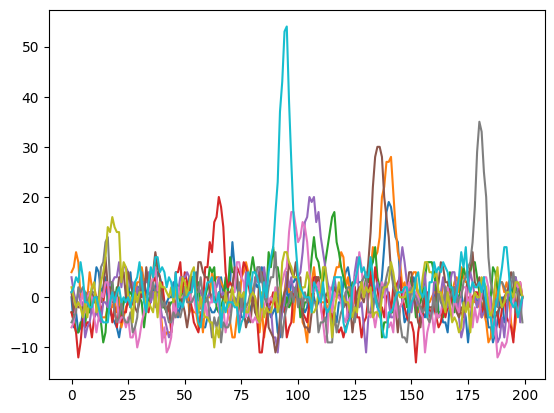

In [5]:
for i in range(10):
    plt.plot(roi_waveforms[i])

In [6]:
nonroi_waveforms = []
for wave_data in data:
    wave = []
    if wave_data[2] == 0:
        for i in range(4, 204):
            wave.append(wave_data[i])
        nonroi_waveforms.append(wave)

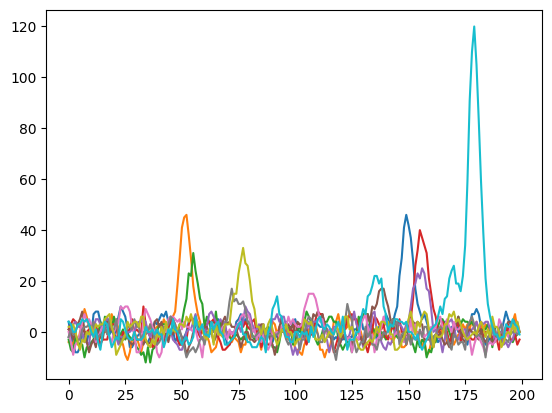

In [7]:
for i in range(10):
    plt.plot(nonroi_waveforms[i])

In [8]:
print(len(roi_waveforms), len(nonroi_waveforms), len(roi_waveforms) + len(nonroi_waveforms), len(data))

291 1999 2290 2307


Look at the 17 waveforms that are not marked as 1 or 0 by the ROI finder

291 1999 2290 2307 17
[2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


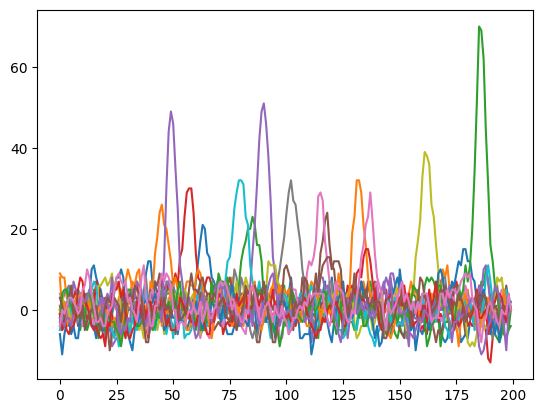

In [9]:
roi_count = 0
nonroi_count = 0
roierr_indicator = []

for wave in data:
    if wave[2] == 1:
        roi_count += 1
    elif wave[2] == 0:
        nonroi_count += 1
    else:
        roierr_indicator.append(wave[2])
        wv = []
        for i in range(4, 204):
            wv.append(wave[i])
        plt.plot(wv)

print(roi_count, nonroi_count, roi_count+nonroi_count, len(data), len(roierr_indicator))
print(roierr_indicator)

In [10]:
# load scales
mean_Z = np.load('../LArTPC-1DCNN-AutoEncoder/Neutrino-Trained/Denoisng_Autoencoder/model_scales/AE_mean_np_Z.npy')
std_Z = np.load('../LArTPC-1DCNN-AutoEncoder/Neutrino-Trained/Denoisng_Autoencoder/model_scales/AE_std_np_Z.npy')
print(mean_Z, std_Z)

2.4530644375 20.379108240498976


In [11]:
all_waveforms = []
for waveform in data:
    wave = []
    for i in range(4, 204):
        wave.append(waveform[i])
    all_waveforms.append(wave)

print(len(all_waveforms), len(all_waveforms[0]))
all_waveforms = np.array(all_waveforms)

2307 200


In [12]:
scaled_wf = (all_waveforms-mean_Z)/std_Z

Load model

In [13]:
autoencoder_Z = load_model('../LArTPC-1DCNN-AutoEncoder/Neutrino-Trained/Denoisng_Autoencoder/models/model_AE_2048_no_poolingZplane_nu.h5')

In [14]:
%%time
predictions = autoencoder_Z.predict(scaled_wf, batch_size=4096)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])



1/1 [==============================] - 1s 720ms/step
CPU times: user 297 ms, sys: 39.7 ms, total: 337 ms
Wall time: 841 ms


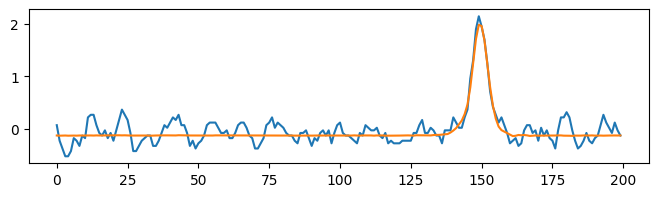

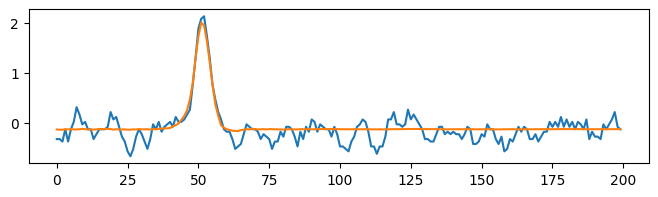

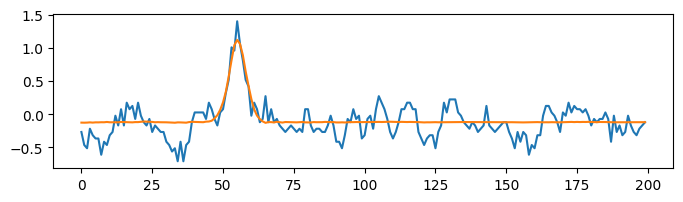

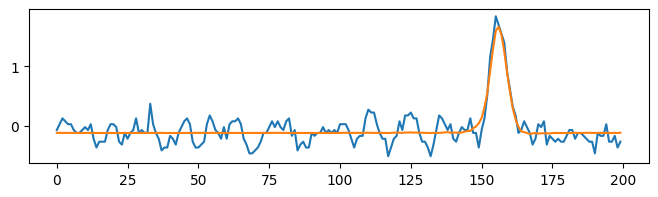

In [15]:
for i in range(4):
    fig = plt.figure(figsize=(8,2))
    plt.plot(scaled_wf[i])
    plt.plot(predictions[i])
    plt.show()

In [16]:
pred = predictions*std_Z+mean_Z

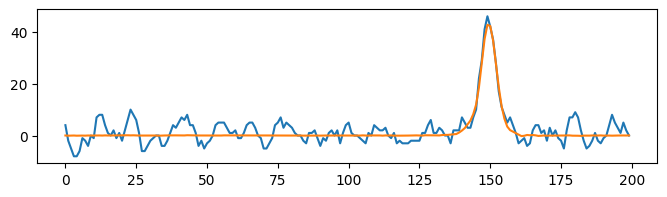

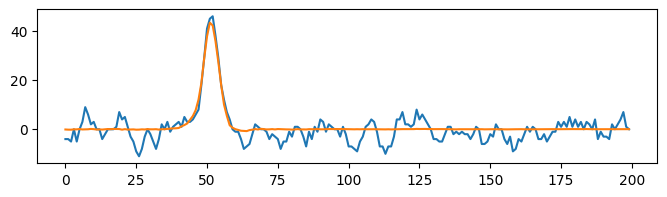

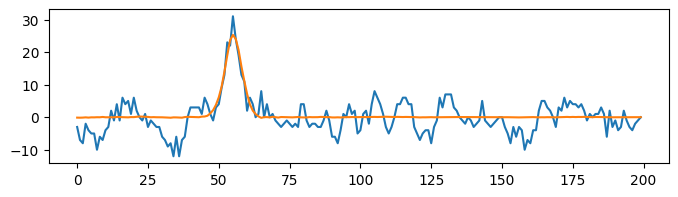

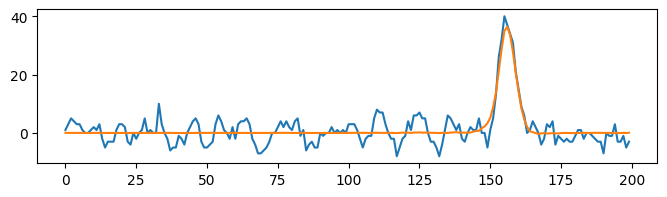

In [17]:
for i in range(4):
    fig = plt.figure(figsize=(8,2))
    plt.plot(all_waveforms[i])
    plt.plot(pred[i])
    plt.show()

USE SAVED_MODEL

In [49]:
loaded_SM = tf.saved_model.load('../LArTPC-1DCNN-AutoEncoder/Neutrino-Trained/Denoisng_Autoencoder/saved_models/saved_modelZ_AE/')
print(list(loaded_SM.signatures.keys()))

['serving_default']


In [50]:
input_signature = loaded_SM.signatures["serving_default"]

In [51]:
reshaped_data = scaled_wf.reshape(-1, 200, 1)
predictions_SM = input_signature(tf.constant(reshaped_data, dtype=tf.float32))
predictions_SM.keys()

dict_keys(['conv1d_transpose_3'])

In [52]:
predictions_out_SM = predictions_SM['conv1d_transpose_3'].numpy()
predictions_out_SM = predictions_out_SM.reshape(scaled_wf.shape)
predictions_out_SM.shape

NameError: name 'predictions_SM' is not defined

In [48]:
import os.path
import time

# Get TensorFlow version
tf_version = tf.__version__

# Get TensorFlow installation path
tf_path = os.path.dirname(tf.__file__)

# Get the installation date by looking at the file modification time
installation_date = time.ctime(os.path.getctime(tf_path))

print(f'TensorFlow Version: {tf_version}')
print(f'TensorFlow Installation Date: {installation_date}')

TensorFlow Version: 2.12.0
TensorFlow Installation Date: Tue Apr 18 19:36:16 2023
